### Pair Correlation for ICM Organoids

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.spatial.distance import cdist
from Functions import *

C = pd.read_csv('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')
    
def paircorrelation(Population, Type, GraphDist):
    x = np.zeros(len(Population))
    x[(Population == Type)] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        dist = GraphDist[ind].T[ind].T
        rho0 = sum(x)/len(x)
        rho1 = (sum(x)-1)/(len(x)-1)


        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = len(dist[dist==i])/len(GraphDist[GraphDist==i])/rho0/rho1

    return P


def correlation_correction(Population, Type, GraphDist):
    x = np.zeros(len(Population))
    y = np.zeros(len(Population))
    x[(Population == Type)] = 1
    y[(Population == 'N+G+') | (Population == 'N-G-')] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    cor_ind = np.where(y==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        equals = GraphDist[ind].T[ind].T
        mixed = GraphDist[cor_ind].T[ind].T
        none =  GraphDist[cor_ind].T[cor_ind].T
        
        rho_equals = sum(x)*(sum(x)-1)/len(x)/(len(x)-1)
        rho_mixed = sum(x)*sum(y)/len(x)/(len(x)-1)
        rho_none = sum(y)*(sum(y)-1)/len(x)/(len(x)-1)
        
        rho_total = (sum(x) + sum(y)/2)*(sum(x)-1 + sum(y)/2)/len(x)/(len(x)-1)

        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = (len(equals[equals==i])/len(GraphDist[GraphDist==i])/rho_total \
                   + len(mixed[mixed==i])/len(GraphDist[GraphDist==i])/rho_total \
                   + 0.25*len(none[none==i])/len(GraphDist[GraphDist==i])/rho_total)

    return P


N = []
G = []
N_cor = []
G_cor = []
DN = []
DP = []
nofCells = []
Stage = []
N_mean = 0
G_mean = 0
DN_mean = 0
DP_mean = 0
number = 0
for K in range(max(C['OrganoidID'])):
    Organoids = max(C['OrganoidID'])
    ID = K+1
    Cindex = []
    Cells = []

    for i in range(len(C)):
        if C['OrganoidID'][i] == ID:
            Cindex.append(i)

    x = np.array(C.loc[Cindex,'CentroidX'])
    y = np.array(C.loc[Cindex,'CentroidY'])
    z = np.array(C.loc[Cindex,'CentroidZ'])
    Nanog = np.array(C.loc[Cindex,'Nanog-Avg'])
    Gata6 = np.array(C.loc[Cindex,'Gata6-Avg'])
    Population = np.array(C.loc[Cindex,'Population'])
    stage = np.array(C.loc[Cindex,'stage'])
    
    nofN = len(Population[Population == 'N+G-'])
    nofG = len(Population[Population == 'N-G+'])
    nofDP = len(Population[Population == 'N+G+'])
    nofDN = len(Population[Population == 'N-G-'])
    
    #if nofDN/len(x) + nofDP/len(x) > 0.25 or stage[0]=='24h' or nofN/nofG < 2 or nofG/nofN < 2:
    #if stage[0]=='24h':
    #if nofG == 0:
    #    nofG = 1e-8
    #if nofN == 0:
    #    nofN = 1e-8
        
    if (nofDN/len(x) + nofDP/len(x) > 0.25 or stage[0]=='24h' or nofN/nofG > 2 or nofG/nofN > 2):
        continue

    #N_mean += nofN/len(x)
    #G_mean += nofG/len(x)
    #DN_mean += nofDN/len(x)
    #DP_mean += nofDP/len(x)
    #number += 1
        
    print('Organoid', ID, 'consists of', len(Cindex), 'cells')

    pos = np.empty([len(x), 3])
    pos[:,0] = x
    pos[:,1] = y
    pos[:,2] = z

    GraphDist = graphdistance3D(pos, cutoff=91)
    
    #Population[Nanog > Gata6] = 'N+G-'
    #Population[Nanog <= Gata6] = 'N-G+'
    N.append(paircorrelation(Population, 'N+G-', GraphDist))
    G.append(paircorrelation(Population, 'N-G+', GraphDist))
    N_cor.append(correlation_correction(Population, 'N+G-', GraphDist))
    G_cor.append(correlation_correction(Population, 'N-G+', GraphDist))
    DN.append(paircorrelation(Population, 'N-G-', GraphDist))
    DP.append(paircorrelation(Population, 'N+G+',GraphDist))
    Stage.append(stage[0])
    nofCells.append(len(x))
    
print('Finished!')

Organoid 14 consists of 1531 cells
Organoid 15 consists of 1474 cells
Organoid 39 consists of 935 cells
Organoid 47 consists of 962 cells
Organoid 50 consists of 812 cells
Organoid 51 consists of 955 cells
Organoid 52 consists of 984 cells
Organoid 53 consists of 751 cells
Organoid 54 consists of 663 cells
Organoid 62 consists of 1051 cells
Finished!


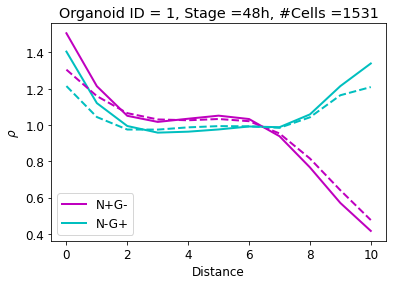

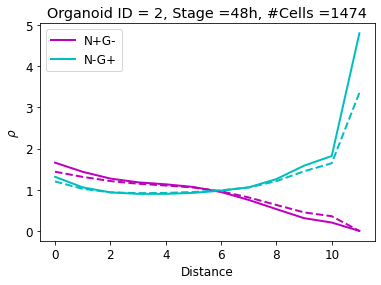

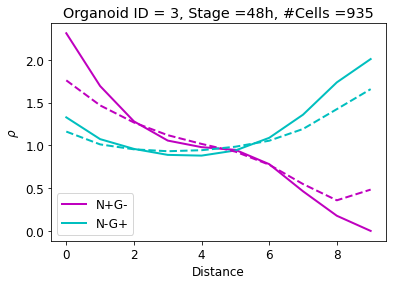

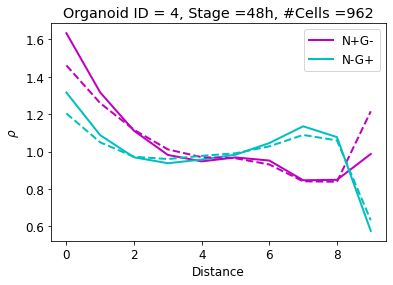

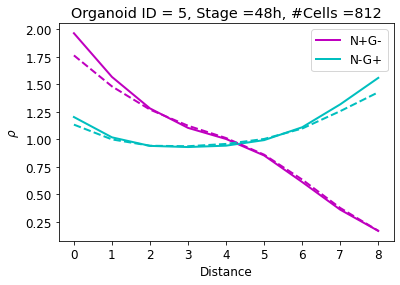

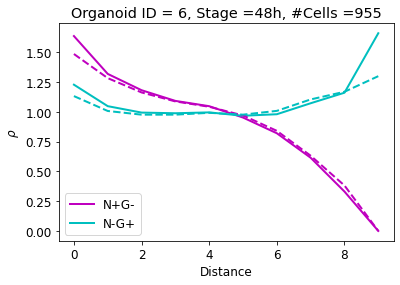

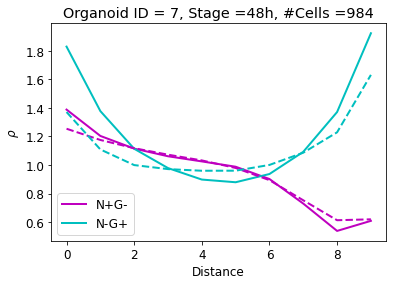

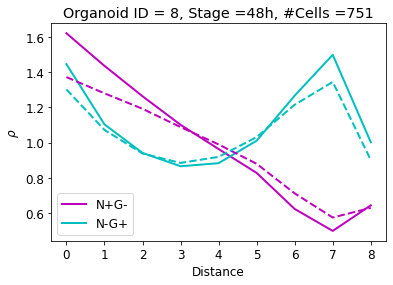

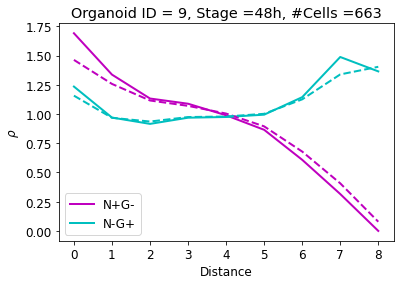

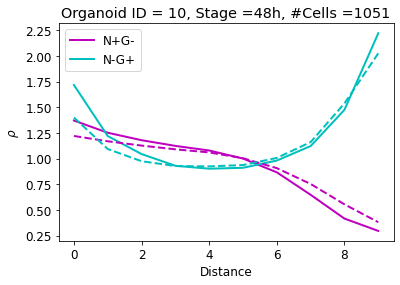

In [17]:
for i in range(len(N)):
    plt.figure()
    plt.rc('font', size=12)
    plt.plot(N[i], 'm', lw=2, label = 'N+G-')
    plt.plot(G[i], 'c', lw=2, label = 'N-G+')
    plt.plot(N_cor[i], 'm--', lw=2)
    plt.plot(G_cor[i], 'c--', lw=2)
    #plt.plot(DP[i], 'k--', alpha = 0.5, lw=2, label = 'N+G+')
    #plt.plot(DN[i], 'k', ls='dotted', alpha = 0.5, lw=2, label = 'N-G-')
    plt.title('Organoid ID = '+str(i+1)+ ', Stage ='+str(Stage[i])+', #Cells ='+str(nofCells[i]))
    plt.xlabel('Distance')
    plt.ylabel('$\\rho$')
    plt.legend()
    #plt.savefig('Results/Pair Correlations (without DN DP)/ID='+str(i+1)+'.png')

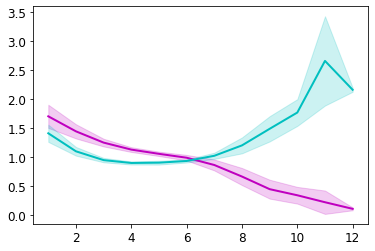

In [3]:
maxdist = 0
for i in range(len(N)):
    if maxdist < len(N[i]):
        maxdist = len(N[i])

amount = np.zeros(maxdist)
N_mean = np.zeros(maxdist)
G_mean = np.zeros(maxdist)
N_std = np.zeros(maxdist)
G_std = np.zeros(maxdist)
DN_mean = np.zeros(maxdist)
DP_mean = np.zeros(maxdist)
DN_std = np.zeros(maxdist)
DP_std = np.zeros(maxdist)
x = list(range(1,maxdist+1))
for i in range(len(N)):
    for j in range(len(N[i])):
        N_mean[j] += N[i][j]
        G_mean[j] += G[i][j]
        DN_mean[j] += DN[i][j]
        DP_mean[j] += DP[i][j]
        amount[j] += 1
        
N_mean = N_mean/amount
G_mean = G_mean/amount


for i in range(len(N)):
    for j in range(len(N[i])):
        N_std[j] += (N[i][j]-N_mean[j])**2
        G_std[j] += (G[i][j]-G_mean[j])**2
        DN_std[j] += (DN[i][j]-DN_mean[j])**2
        DP_std[j] += (DP[i][j]-DP_mean[j])**2
        amount[j] += 1

N_std = (N_std/amount)**(1/2)
G_std = (G_std/amount)**(1/2)
DN_std = (DN_std/amount)**(1/2)
DP_std = (DP_std/amount)**(1/2)
        
plt.plot(x, N_mean, 'm', lw = 2)
plt.plot(x, G_mean, 'c', lw = 2)
#plt.plot(x, DN_mean, 'k', lw = 2)
#plt.plot(x, DP_mean, 'b', lw = 2)
plt.fill_between(x, N_mean - N_std, N_mean + N_std, color='m', alpha = 0.2)
plt.fill_between(x, G_mean - G_std, G_mean + G_std, color='c', alpha = 0.2)
#plt.fill_between(x, DN_mean - DN_std, DN_mean + DN_std, color='k', alpha = 0.2)
#plt.fill_between(x, DP_mean - DP_std, DP_mean + DP_std, color='b', alpha = 0.2)

<br>
<br>
<br>

### Pair correlation for non-local model data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import loadData, fate
import networkx as nx

N = np.empty([9,177])
G = np.empty([9,177])

Pos, Radius, N[0,:], G[0,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=1_10/Data.csv')
Pos, Radius, N[1,:], G[1,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=2_10/Data.csv')
Pos, Radius, N[2,:], G[2,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=3_10/Data.csv')
Pos, Radius, N[3,:], G[3,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=4_10/Data.csv')
Pos, Radius, N[4,:], G[4,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=5_10/Data.csv')
Pos, Radius, N[5,:], G[5,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=6_10/Data.csv')
Pos, Radius, N[6,:], G[6,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=7_10/Data.csv')
Pos, Radius, N[7,:], G[7,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=8_10/Data.csv')
Pos, Radius, N[8,:], G[8,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=9_10/Data.csv')

FVmesh = initializeFVmesh(Pos, Radius=Radius)
Gr = nx.Graph()
for path in FVmesh.Tri.simplices:

    path1 = [path[0], path[1]]
    path2 = [path[1], path[2]]
    path3 = [path[2], path[0]]

    if FVmesh.Dist[path1[0],path1[1]] < 2.2:
        nx.add_path(Gr, path1)
    if FVmesh.Dist[path2[0],path2[1]] < 2.2:    
        nx.add_path(Gr, path2)
    if FVmesh.Dist[path3[0],path3[1]] < 2.2:
        nx.add_path(Gr, path3)
    
dist_dict = dict(nx.all_pairs_dijkstra_path_length(Gr))
GraphDist = np.empty([FVmesh.nofCells, FVmesh.nofCells])
for i in range(FVmesh.nofCells):
    for j in range(FVmesh.nofCells):
        GraphDist[i,j] = dist_dict[i][j]

colors = np.linspace(0,1,9)       
cmap = matplotlib.cm.get_cmap('jet')
plt.figure(figsize=[6.4, 4.8])
for i in range(len(N)):
    rgba = cmap(colors[i])
    x = np.array(fate(N[i,:], G[i,:]))
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    dist = GraphDist[ind].T[ind].T
    rho0 = sum(x)/len(x)
    rho1 = (sum(x)-1)/(len(x)-1)

    Px = np.empty(maxdist)
    for k in range(1,maxdist+1):
        Px[k-1] = len(dist[dist==k])/len(GraphDist[GraphDist==k])/rho0/rho1
        
    plt.rc('font', size=14)
    distances = [j for j in range(1,int(np.max(GraphDist))+1)]
    plt.plot(distances, Px, lw=2, label='$q = '+str((i+1)/10)+'$', color=rgba)
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_n$')

test = np.linspace(0,1,len(PN)-2)
plt.axhline(1, color='k', lw=2, linestyle='--')
plt.legend(ncol=2)
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_nonlocal.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_nonlocal.png')

plt.figure(figsize=[6.4, 4.8])
for i in range(len(N)):
    rgba = cmap(colors[i])
    x = np.array(fate(G[i,:], N[i,:]))
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    dist = GraphDist[ind].T[ind].T
    rho0 = sum(x)/len(x)
    rho1 = (sum(x)-1)/(len(x)-1)

    Px = np.empty(maxdist)
    for k in range(1,maxdist+1):
        Px[k-1] = len(dist[dist==k])/len(GraphDist[GraphDist==k])/rho0/rho1
        
    plt.rc('font', size=14)
    distances = [j for j in range(1,int(np.max(GraphDist))+1)]
    plt.plot(distances, Px, lw=2, label='$q = '+str((i+1)/10)+'$', color=rgba)
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_g$')

plt.axhline(1, color='k', lw=2, linestyle='--')
plt.legend(ncol=2)
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_nonlocal.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_nonlocal.png')

<br>
<br>
<br>

### Pair correlation / cell ratio for local model data

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0, 0.5, 'Proportion')

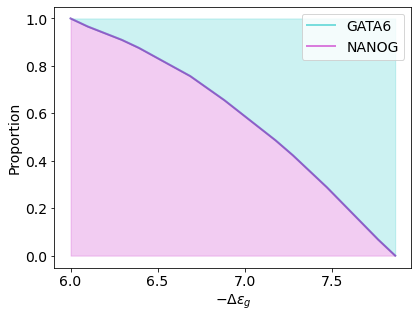

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from Organoid2D import Organoid

org = Organoid()
s_max = org.r_G/org.gamma_G
upper_boundary = -org.eps_N + np.log(1 + np.exp(-org.eps_S-org.eps_NS)*s_max)
eps_G = np.linspace(-org.eps_N, upper_boundary, 20)
Ratio = np.empty(eps_G.shape)

for i in range(len(eps_G)):
    org = Organoid()
    org.q = 0.9
    org.nofSteps = 3000
    org.eps_G = -eps_G[i]
    org.evolution(T = 240, file = "Organoid_mid.csv", mode = 'transcription')
    F = [1 if org.N[i] >= org.G[i] else 0 for i in range(org.nofCells)]
    Ratio[i] = np.sum(F)/org.nofCells
    print(i)


plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
plt.plot(eps_G, Ratio, 'c', alpha=0.5, lw=2, label = 'GATA6')
plt.plot(eps_G, Ratio, 'm', alpha=0.5, lw=2, label = 'NANOG')
plt.fill_between(eps_G, Ratio, 1, color='c', alpha = 0.2)
plt.fill_between(eps_G, 0, Ratio, color='m', alpha = 0.2)
plt.legend()
plt.xlabel('$-\Delta\epsilon_g$')
plt.ylabel('Proportion')

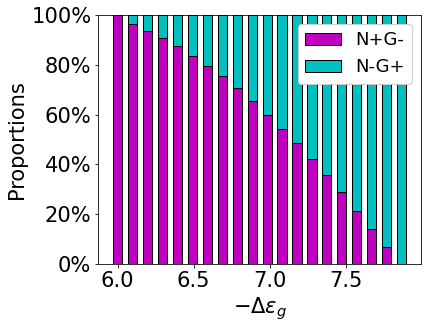

In [124]:
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14*1.5)
plt.bar(eps_G, Ratio*100, width=0.06, color = 'm', edgecolor='k', alpha = 1, label='N+G-')
plt.bar(eps_G, (1-Ratio)*100, bottom=Ratio*100, width=0.06, color = 'c', edgecolor='k', alpha = 1, label='N-G+')
ticks = [0,20,40,60,80,100]
plt.yticks(ticks, [str(x)+'%' for x in ticks])
plt.xlabel('$-\Delta\epsilon_g$')
plt.ylabel('Proportions')
plt.gcf().subplots_adjust(bottom=0.16)
plt.gcf().subplots_adjust(left=0.2)
plt.legend(framealpha=1, fontsize=18)
plt.savefig('Results/Publications/Signal Range/Proportions q=0.9.pdf')
plt.savefig('Results/Publications/Signal Range/Proportions q=0.9.png')

In [ ]:
PN_mean = np.mean(PN, axis=0)
PN_std = np.std(PN, axis=0)
PG_mean = np.mean(PG, axis=0)
PG_std = np.std(PG, axis=0)


plt.figure()
plt.rc('font', size=14)
distances = [j for j in range(1,int(np.max(FVmesh.GraphDist))+1)]
plt.plot(distances, PN_mean, 'm')
plt.fill_between(distances, PN_mean-PN_std, PN_mean+PN_std, color='m', alpha = 0.2)
plt.ylim([0,2])

plt.rc('font', size=14)
distances = [j for j in range(1,int(np.max(FVmesh.GraphDist))+1)]
plt.plot(distances, PG_mean, 'c')
plt.fill_between(distances, PG_mean-PG_std, PG_mean+PG_std, color='c', alpha = 0.2)

In [ ]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,len(PN)-2)
distances = [j for j in range(1,int(np.max(FVmesh.GraphDist))+1)]
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for i in range(len(PN)-2):
    rgba = cmap(test[i])
    
    plt.plot(distances,PN[i+1,:], color = rgba, lw=2)
    
plt.xlabel('Distance')
plt.ylabel('$\\rho_n$')
plt.ylim([0-0.12, max([np.max(PN), np.max(PG)])+0.12])
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_local.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_local.png')

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for i in range(len(PG)-2):
    rgba = cmap(test[i])
    
    plt.plot(distances,PG[i+1,:], color = rgba, lw=2)
    
plt.xlabel('Distance')
plt.ylabel('$\\rho_g$')
plt.ylim([0-0.12, max([np.max(PN), np.max(PG)])+0.12])
#sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
#cbar = plt.colorbar(sm)
#cbar.ax.set_yticklabels([])
#cbar.set_label('$-\Delta\epsilon_g$')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_local.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_local.png')

In [ ]:
a = np.array([[6,7.86]])
plt.figure(figsize=(10, 4))
img = plt.imshow(a, cmap="jet")
plt.gca().set_visible(False)
plt.colorbar(orientation="vertical", label='$-\Delta\epsilon_g$', ticks=[6,6.93,7.86])
plt.savefig("Results/Publications/Pattern Formation/colorbar_local.pdf")
plt.savefig("Results/Publications/Pattern Formation/colorbar_local.png")

<br>
<br>
<br>

### ML Training Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import coverPlot, saveData, paircorrelation, fate
from Model import rhs_activation
from Parameters import setParameters
from scipy.integrate import solve_ivp
import pandas as pd

Prm = setParameters()
#Organoid = initializeOrganoid(Prm, Transcription=False, CellMax=150)
#Pos = Organoid.Pos
#FVmesh = initializeFVmesh(Pos, Radius=Organoid.Radius)

DATA = pd.DataFrame()
for i in range(1000):
    #Prm.eps_G = -10.7
    q = np.random.uniform(0,1)
    Prm.range = q
    Prm.nofCells_end = 300# + np.random.normal(0,10)
    Organoid = initializeOrganoid(Prm, Transcription=False, CellMax=150)
    Pos = Organoid.Pos
    FVmesh = initializeFVmesh(Pos, Radius=Organoid.Radius*1.2)
    #Pos = np.array(pd.read_csv('testOrganoid_small.csv'))
    #Radius = np.ones(len(Pos))*1.1
    #FVmesh = initializeFVmesh(Pos, Radius=Organoid.Radius)

    d_ij = FVmesh.GraphDist
    np.fill_diagonal(d_ij, 0)
    s_max = np.max(np.sum(Prm.r_G/Prm.gamma_G*q**d_ij, axis=1))/max(np.sum(q**d_ij, axis=1))
    upper_boundary = -Prm.eps_N + np.log(1 + np.exp(-Prm.eps_S-Prm.eps_NS)*s_max)
    #Prm.eps_G = -np.random.uniform(-Prm.eps_N, upper_boundary)
    Prm.eps_G = -7
    print('eps_G =', Prm.eps_G, upper_boundary)

    t = np.linspace(0,Prm.T,Prm.nofSteps)

    x0 = [Prm.r_N/Prm.gamma_N*3/4, Prm.r_G/Prm.gamma_G*3/4]
    xInit = np.append(np.random.normal(x0[0], x0[0]*0.01, FVmesh.nofCells),
                      np.random.normal(x0[1], x0[1]*0.01, FVmesh.nofCells))
    rhs = lambda t,x: rhs_activation(0, x, Prm, FVmesh)
    sol = solve_ivp(rhs, [0,Prm.T], xInit, t_eval = t, method = 'Radau')

    N = sol.y[:FVmesh.nofCells,-1]
    G = sol.y[FVmesh.nofCells:,-1]
    F = fate(N,G)

    print('ID =', i, 'Total =', len(N), 'NANOG =', len(N[N>G]), 'GATA6 =', len(G[G>N]))

    df = pd.DataFrame()
    df['ID'] = i*np.ones(len(F), dtype=int)
    df['x'] = Pos[:,0]
    df['y'] = Pos[:,1]
    df['fate'] = F
    df['range'] = q
    DATA = DATA.append(df)

DATA.to_csv('C:/Users/sis85wc/Desktop/ML Training Data/varying range+constrained ratio (Jonas)/Organoids.csv', index=False)

with open('C:/Users/sis85wc/Desktop/ML Training Data/varying range+constrained ratio (Jonas)/Organoids.txt', 'w') as f:
    print('Energy differences---------------------', file=f)
    print('eps_N =', Prm.eps_N, file=f)
    print('eps_G =', Prm.eps_G, file=f)
    print('eps_S =', Prm.eps_S, file=f)
    print('eps_NS =', Prm.eps_NS, file=f)
    print('', file=f)

    print('Reproduction rates---------------------', file=f)
    print('r_N =', Prm.r_N, file=f)
    print('r_G =', Prm.r_G, file=f)
    print('', file=f)

    print('Decay rates----------------------------', file=f)
    print('gamma_N =', Prm.gamma_N, file=f)
    print('gamma_G =', Prm.gamma_G, file=f)
    print('', file=f)

    print('Signal parameters----------------------', file=f)
    print('signal =', Prm.range, file=f)

Expected cell division time = 4.7441202514160725
Expected number of Cells = 193.17431641584017
eps_G = -7 7.865600680126628
ID = 0 Total = 150 NANOG = 60 GATA6 = 90
Expected cell division time = 4.7441202514160725
Expected number of Cells = 193.17431641584017
eps_G = -7 7.865600680126628
ID = 1 Total = 150 NANOG = 70 GATA6 = 80
Expected cell division time = 4.7441202514160725
Expected number of Cells = 193.17431641584017
eps_G = -7 7.865600680126627
ID = 2 Total = 150 NANOG = 80 GATA6 = 70
Expected cell division time = 4.7441202514160725
Expected number of Cells = 193.17431641584017
eps_G = -7 7.865600680126628
ID = 3 Total = 150 NANOG = 71 GATA6 = 79
Expected cell division time = 4.7441202514160725
Expected number of Cells = 193.17431641584017
eps_G = -7 7.865600680126628
ID = 4 Total = 150 NANOG = 84 GATA6 = 66
Expected cell division time = 4.7441202514160725
Expected number of Cells = 193.17431641584017
eps_G = -7 7.865600680126628
ID = 5 Total = 150 NANOG = 73 GATA6 = 77
Expected c

In [3]:
from Organoid3D import Organoid
from Functions import fate
import pandas as pd
import numpy as np

Q = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for q in Q:
    DATA = pd.DataFrame()
    for i in range(100):
        org = Organoid()
        org.q = q
        org.evolution(T=25, mode='geometry')
        org.evolution(T=25, mode='transcription')
        F = fate(org.N,org.G)

        print('ID =', i, 'Total =', len(org.N), 'NANOG =', len(org.N[org.N>org.G]), 'GATA6 =', len(org.G[org.G>org.N]))

        df = pd.DataFrame()
        df['ID'] = i*np.ones(len(F), dtype=int)
        df['x'] = org.xyz[:,0]
        df['y'] = org.xyz[:,1]
        df['z'] = org.xyz[:,2]
        df['fate'] = F
        DATA = DATA.append(df)
    
    DATA.to_csv('C:/Users/sis85wc/Desktop/ML Training Data/varying cell numbers 3D (Robin)/Organoids q='+str(q)+'.csv', index=False)

ID = 0 Total = 334 NANOG = 137 GATA6 = 197
ID = 1 Total = 359 NANOG = 156 GATA6 = 203
ID = 2 Total = 298 NANOG = 126 GATA6 = 172
ID = 3 Total = 357 NANOG = 152 GATA6 = 205
ID = 4 Total = 326 NANOG = 139 GATA6 = 187
ID = 5 Total = 286 NANOG = 124 GATA6 = 162
ID = 6 Total = 362 NANOG = 159 GATA6 = 203
ID = 7 Total = 319 NANOG = 128 GATA6 = 191
ID = 8 Total = 327 NANOG = 134 GATA6 = 193
ID = 9 Total = 338 NANOG = 141 GATA6 = 197
ID = 10 Total = 290 NANOG = 127 GATA6 = 163
ID = 11 Total = 299 NANOG = 124 GATA6 = 175
ID = 12 Total = 356 NANOG = 161 GATA6 = 195
ID = 13 Total = 313 NANOG = 131 GATA6 = 182
ID = 14 Total = 353 NANOG = 147 GATA6 = 206
ID = 15 Total = 359 NANOG = 151 GATA6 = 208
ID = 16 Total = 340 NANOG = 148 GATA6 = 192
ID = 17 Total = 308 NANOG = 127 GATA6 = 181
ID = 18 Total = 304 NANOG = 122 GATA6 = 182
ID = 19 Total = 308 NANOG = 129 GATA6 = 179
ID = 20 Total = 328 NANOG = 129 GATA6 = 199
ID = 21 Total = 300 NANOG = 133 GATA6 = 167
ID = 22 Total = 344 NANOG = 151 GATA6 = 19

In [1]:
from Organoid3D import Organoid
from scipy.spatial import Delaunay
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
import itertools

org = Organoid()
org.evolution(T=28, mode='geometry')
org.evolution(T=20, mode='transcription')
org.cellPlot(org.N, size=0)


### Simulation on Organoid Geometry

In [86]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.spatial.distance import cdist
from scipy.spatial import Delaunay
from FVmesh import initializeFVmesh
from Parameters import setParameters
from Model import rhs_activation

#### Import Geometry ####
Data = pd.read_csv('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')


ID = 20 # 14, 20, 29, 52, 62, 68
q = 0.4


Data = Data[Data['OrganoidID']==ID]
print('Organoid', ID, 'is', Data.iloc[0,1], 'old')
print('Organoid', ID, 'consists of', len(Data), 'cells')
x = np.array(Data['CentroidX'])
y = np.array(Data['CentroidY'])
z = np.array(Data['CentroidZ'])
Pop = np.array(Data['Population'])
pos = np.empty([len(x), 3])
pos[:,0] = x
pos[:,1] = y
pos[:,2] = z

Dist = cdist(pos, pos)
cutoff = 91
def graphdistance(tri):
    Gr = nx.Graph()
    
    simplices = tri.simplices[(Dist[tri.simplices[:,0],tri.simplices[:,1]] < cutoff) & 
                              (Dist[tri.simplices[:,0],tri.simplices[:,2]] < cutoff) &
                              (Dist[tri.simplices[:,0],tri.simplices[:,3]] < cutoff) &
                              (Dist[tri.simplices[:,1],tri.simplices[:,2]] < cutoff) & 
                              (Dist[tri.simplices[:,1],tri.simplices[:,3]] < cutoff) &
                              (Dist[tri.simplices[:,2],tri.simplices[:,3]] < cutoff)]
    
    for path in simplices:
        nx.add_path(Gr, path)
        
    dist_dict = dict(nx.all_pairs_dijkstra_path_length(Gr))
    dist = np.empty([len(x), len(x)])
    for i in range(len(x)):
        for j in range(len(x)):
            dist[i,j] = dist_dict[i][j]
            
    
    return dist

tri = Delaunay(pos)
GraphDist = graphdistance(tri)

#### Initialize Parameters ####
Prm = setParameters()
ranges = np.linspace(0.1, 0.9, 9)

#### Initialize Mesh ####
FVmesh = initializeFVmesh(pos, reduced=True)
FVmesh.GraphDist = GraphDist

s_max = np.max((1-q)/q*np.sum(Prm.r_G/Prm.gamma_G*q**GraphDist, axis=0))
lower_boundary = -Prm.eps_N
upper_boundary = -Prm.eps_N + np.log(1 + np.exp(-Prm.eps_S-Prm.eps_NS)*s_max)

eps_G = (lower_boundary+upper_boundary)/2

nofCalc = 0
r = 0
ratio = len(x[Pop=='N+G-'])/len(x[Pop=='N-G+'])
offset = 0.1
while r < ratio - offset or r > ratio + offset and nofCalc < 10:

    Prm.T = 24
    Prm.nofSteps = 3000
    Prm.range = q
    Prm.eps_G = -eps_G

    t = np.linspace(0,Prm.T,Prm.nofSteps)

    x0 = [Prm.r_N/Prm.gamma_N*3/4, Prm.r_G/Prm.gamma_G*3/4]
    xInit = np.append(np.random.normal(x0[0], x0[0]*0.01, FVmesh.nofCells),
                      np.random.normal(x0[1], x0[1]*0.01, FVmesh.nofCells))
    rhs = lambda t,x: rhs_activation(0, x, Prm, FVmesh)
    x = np.empty([2*FVmesh.nofCells, Prm.nofSteps])
    x[:,0] = xInit

    for i in range(1, len(t)):
        x[:,i] = x[:,i-1] + (t[i]-t[i-1])*rhs(t[i-1],x[:,i-1])

    N = x[:FVmesh.nofCells,-1]
    G = x[FVmesh.nofCells:,-1]
    
    r = len(N[N>G])/len(G[G>N])
    eps_G0 = eps_G
    nofCalc += 1
    
    if r > ratio:
        lower_boundary = eps_G
        eps_G = (lower_boundary+upper_boundary)/2
    elif r <= ratio:
        upper_boundary = eps_G
        eps_G = (lower_boundary+upper_boundary)/2
        
    print('Iteration: '+str(nofCalc)+', Aim: '+str(ratio)+', Current: '+str(r))

df = pd.DataFrame()
df['x'] = pos[:,0]
df['y'] = pos[:,1]
df['z'] = pos[:,2]
df['Nanog'] = N
df['Gata6'] = G
df['eps_G'] = eps_G0

df.to_csv('C:/Users/sis85wc/Desktop/Cell-Differentiation/Results/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+'.csv', index=False)
print('Finished!!!')

Organoid 20 is 48h old
Organoid 20 consists of 1410 cells
Iteration: 1, Aim: 0.6086261980830671, Current: 7.1502890173410405
Iteration: 2, Aim: 0.6086261980830671, Current: 1.3898305084745763
Iteration: 3, Aim: 0.6086261980830671, Current: 0.34541984732824427
Iteration: 4, Aim: 0.6086261980830671, Current: 0.7691342534504392
Iteration: 5, Aim: 0.6086261980830671, Current: 0.532608695652174
Finished!!!


Organoid 20 is 48h old
Organoid 20 consists of 1410 cells
Organoid 20 consists of 381 NANOG cells
Organoid 20 consists of 626 GATA6 cells
Organoid 20 has a NANOG:GATA6 ratio of 0.6086261980830671


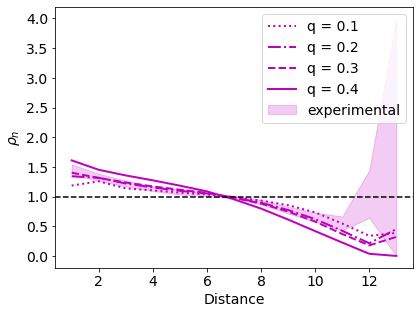

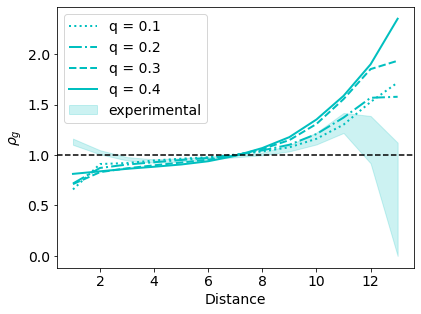

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Functions import graphdistance3D, loadExpData, pc_bounds

def paircorrelation(N, G, GraphDist):
    x = np.zeros(len(N))
    x[N > G] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        dist = GraphDist[ind].T[ind].T
        rho0 = sum(x)/len(x)
        rho1 = (sum(x)-1)/(len(x)-1)


        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = len(dist[dist==i])/len(GraphDist[GraphDist==i])/rho0/rho1

    return P

ID = 20
#q = 0.2

N, G, Pop, Pos = loadExpData(ID)
GraphDist = graphdistance3D(Pos)
PN_min, PN_max, PG_min, PG_max = pc_bounds(Pop, GraphDist, 1000)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for q in [0.1,0.2,0.3,0.4]:
    Data = pd.read_csv('C:/Users/sis85wc/Desktop/Cell-Differentiation/Results/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+'.csv')
    N = Data['Nanog']
    G = Data['Gata6']

    PN = paircorrelation(N, G, GraphDist)
    ranges = list(range(1,len(PN)+1))

    if q == 0.1:
        style = 'dotted'
    elif q == 0.2:
        style = 'dashdot'
    elif q == 0.3:
        style = 'dashed'
    else:
        style = 'solid'
        
    plt.plot(ranges, PN, 'm', lw=2, linestyle=style, label='q = '+str(q))
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_n$')


plt.axhline(1, color='black', linestyle='dashed')
plt.fill_between(ranges, PN_min, PN_max, color='m', alpha=0.2, label='experimental')
plt.legend()
plt.savefig("Results/Publications/Pattern Formation/PCF NANOG ID = " + str(ID) + ".pdf")
plt.savefig("Results/Publications/Pattern Formation/PCF NANOG ID = " + str(ID) + ".png")

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for q in [0.1,0.2,0.3,0.4]:
    Data = pd.read_csv('C:/Users/sis85wc/Desktop/Cell-Differentiation/Results/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+'.csv')
    N = Data['Nanog']
    G = Data['Gata6']

    PG = paircorrelation(G, N, GraphDist)
    ranges = list(range(1,len(PN)+1))

    if q == 0.1:
        style = 'dotted'
    elif q == 0.2:
        style = 'dashdot'
    elif q == 0.3:
        style = 'dashed'
    else:
        style = 'solid'
 
    plt.plot(ranges, PG, 'c', lw=2, linestyle=style, label='q = '+str(q))
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_g$')

plt.axhline(1, color='black', linestyle='dashed')
plt.fill_between(ranges, PG_min, PG_max, color='c', alpha=0.2, label='experimental')
plt.legend()
plt.savefig("Results/Publications/Pattern Formation/PCF GATA6 ID = " + str(ID) + ".pdf")
plt.savefig("Results/Publications/Pattern Formation/PCF GATA6 ID = " + str(ID) + ".png")

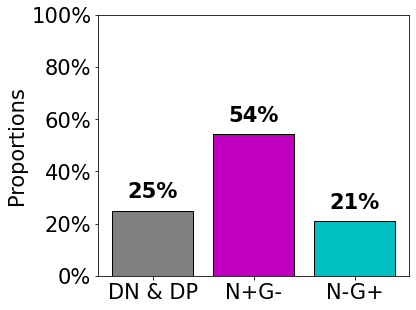

In [22]:
from ExpData import ExpData
import matplotlib.pyplot as plt

ID = 65 # 14, 29, 52, 62, 7, 65 (20, 68)

dat = ExpData('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14*3/2)
dat.propPlot(ID)
plt.gcf().subplots_adjust(left=0.15*3/2)
plt.savefig("Results/Publications/Signal Range/Proportions ID = " + str(ID) + ".pdf", transparent=True)
plt.savefig("Results/Publications/Signal Range/Proportions ID = " + str(ID) + ".png", transparent=True)

In [16]:
dat.info(7)
print(1751 - 291 - 67)

Organoid 7 is 48h old
Organoid 7 consists of 1751 cells
Organoid 7 consists of 291 NANOG cells
Organoid 7 consists of 67 GATA6 cells
1393


Expected cell division time = 3.53156223514816
Expected number of Cells = 861.8099494976175
Organoid with 884 cells is ready!


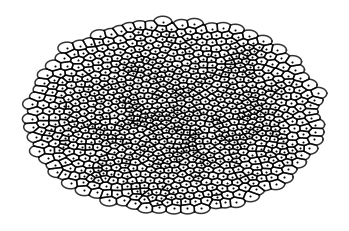

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import coverPlot, saveData, paircorrelation, fate
from Model import rhs_activation
from Parameters import setParameters
from scipy.integrate import solve_ivp
import pandas as pd

DATA = pd.DataFrame()

Prm = setParameters()
Prm.nofCells_end = 1000
Organoid = initializeOrganoid(Prm, Transcription=False)
print("Organoid with " + str(len(Organoid.Pos)) + " cells is ready!")

FVmesh = initializeFVmesh(Organoid.Pos, Radius = np.ones(len(Organoid.Pos))*np.mean(Organoid.Radius))
FVmesh.plot()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import coverPlot, saveData, paircorrelation, fate
from Model import rhs_activation
from Parameters import setParameters
from scipy.integrate import solve_ivp
import pandas as pd

Prm = setParameters()
Prm.T = 240
Prm.nofSteps = 30000
t = np.linspace(0,Prm.T,Prm.nofSteps)

orgdata = pd.read_csv('ratio_size_comparison.csv')

for j in [-6.5,-7,-7.5]:
    DATA = pd.DataFrame()
    for i in range(max(orgdata['ID'])):

        data = orgdata[orgdata['ID']==i]
        Prm.eps_G = j
        x = data['x'].to_numpy()
        y = data['y'].to_numpy()
        Pos = np.concatenate(([x], [y]), axis=0).T
        FVmesh = initializeFVmesh(Pos, Radius = np.ones(len(Pos))*0.8)

        x0 = [Prm.r_N/Prm.gamma_N*3/4, Prm.r_G/Prm.gamma_G*3/4]
        xInit = np.append(np.random.normal(x0[0], x0[0]*0.01, FVmesh.nofCells),
                          np.random.normal(x0[1], x0[1]*0.01, FVmesh.nofCells))
        rhs = lambda t,x: rhs_activation(0, x, Prm, FVmesh)
        sol = np.empty([2*FVmesh.nofCells, Prm.nofSteps+1])
        sol[:,0] = xInit
        for k in range(Prm.nofSteps):
            sol[:,k+1] = sol[:,k] + (t[1]-t[0])*rhs(t[k], sol[:,k])

        N = sol[:FVmesh.nofCells,-1]
        G = sol[FVmesh.nofCells:,-1]
        F = fate(N,G)

        print('ID =', i, 'Total =', len(N), 'NANOG =', len(N[N>G]), 'GATA6 =', len(G[G>N]))

        df = pd.DataFrame()
        df['ID'] = i*np.ones(len(F), dtype=int)
        df['x'] = Pos[:,0]
        df['y'] = Pos[:,1]
        df['fate'] = F
        df['NANOG'] = N
        df['GATA6'] = G
        DATA = DATA.append(df)

    DATA.to_csv('tissue_size_comparison'+str(-j)+'.csv', index=False)

ID = 0 Total = 9 NANOG = 6 GATA6 = 3
ID = 1 Total = 9 NANOG = 7 GATA6 = 2
ID = 2 Total = 9 NANOG = 5 GATA6 = 4
ID = 3 Total = 9 NANOG = 6 GATA6 = 3
ID = 4 Total = 9 NANOG = 6 GATA6 = 3
ID = 5 Total = 10 NANOG = 7 GATA6 = 3
ID = 6 Total = 10 NANOG = 7 GATA6 = 3
ID = 7 Total = 10 NANOG = 7 GATA6 = 3
ID = 8 Total = 12 NANOG = 9 GATA6 = 3
ID = 9 Total = 12 NANOG = 7 GATA6 = 5
ID = 10 Total = 12 NANOG = 8 GATA6 = 4
ID = 11 Total = 12 NANOG = 8 GATA6 = 4
ID = 12 Total = 13 NANOG = 9 GATA6 = 4
ID = 13 Total = 15 NANOG = 10 GATA6 = 5
ID = 14 Total = 15 NANOG = 10 GATA6 = 5
ID = 15 Total = 17 NANOG = 12 GATA6 = 5
ID = 16 Total = 17 NANOG = 12 GATA6 = 5
ID = 17 Total = 18 NANOG = 12 GATA6 = 6
ID = 18 Total = 19 NANOG = 13 GATA6 = 6
ID = 19 Total = 19 NANOG = 13 GATA6 = 6
ID = 20 Total = 19 NANOG = 14 GATA6 = 5
ID = 21 Total = 20 NANOG = 15 GATA6 = 5
ID = 22 Total = 21 NANOG = 14 GATA6 = 7
ID = 23 Total = 21 NANOG = 14 GATA6 = 7
ID = 24 Total = 22 NANOG = 15 GATA6 = 7
ID = 25 Total = 24 NANOG = 1

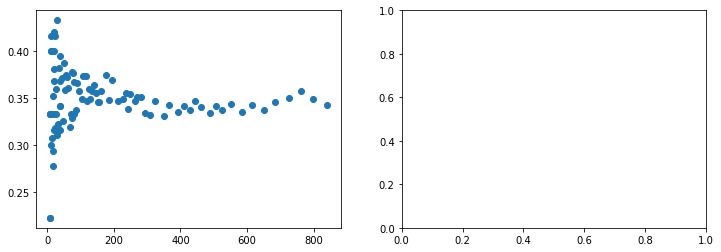

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from FVmesh import initializeFVmesh

DATA = pd.read_csv('tissue_size_comparison7.csv')

IDs = np.unique(DATA['ID'])
size = np.empty(len(IDs))
nofN = np.empty(len(IDs))
nofG = np.empty(len(IDs))
ratio = np.empty(len(IDs))
nofNeigh = np.zeros(len(IDs))
for i in IDs:
    org = DATA[DATA['ID'] == i]
    size[i] = len(org)
    nofN[i] = len(org[org['fate'] == 1])/len(org)
    nofG[i] = len(org[org['fate'] == 0])/len(org)
    ratio[i] = len(org[org['fate'] == 1])/len(org[org['fate'] == 0])
    
    x = org['x'].to_numpy()
    y = org['y'].to_numpy()

    Pos = np.concatenate(([x], [y]), axis=0).T
    #FVmesh = initializeFVmesh(Pos, Radius = 0.8*np.ones(len(Pos)))
    #for k in FVmesh.Neigh:
    #    nofNeigh[i] += len(k)/len(org)
    
    
def f(x, a, b):
    return a*x**(-1/2)+b

from scipy.optimize import curve_fit

plt.figure(figsize=(12,4))
plt.subplot(121)
popt, pcov = curve_fit(f, size, nofG)
plt.scatter(size, nofG)
#plt.plot(size, f(size, *popt), 'r')

plt.subplot(122)
#plt.scatter(size, nofNeigh)

(-9.872881952040313, 10.177833703173237, -9.74660368520022, 9.98459920107164)

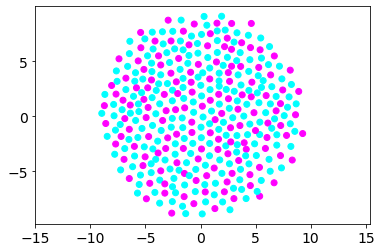

In [60]:
org = DATA[DATA['ID'] == 80]

F = org['fate'].to_numpy()
x = org['x'].to_numpy()
y = org['y'].to_numpy()

plt.scatter(x, y, c=F, cmap='cool')
plt.axis('equal')

[0.65134851] [5.01824884]


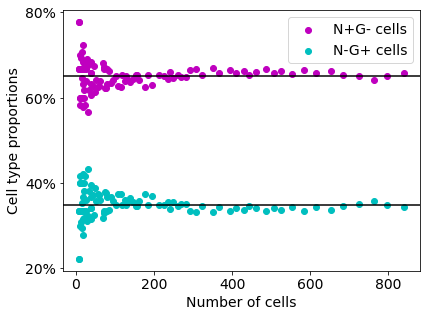

In [85]:
def f(x, a):
    return a*np.ones(len(x))

def g(x, a):
    return a*np.ones(len(x))

def h(x, a, b):
    return  a/g(x, *[-2*np.pi**(1/2)*1.67, 6]) + b

def k(x, a, b):
    return  a*g(x, *[-2*np.pi**(1/2)*1.67, 6]) + b
    

popt_f, pcov = curve_fit(f, size, nofN)
popt_g, pcov = curve_fit(g, size, nofNeigh)
print(popt_f, popt_g)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
plt.scatter(size, nofN*100, color='m', label='N+G- cells')
plt.scatter(size, nofG*100, color='c', label='N-G+ cells')
#plt.plot(size, f(size, *popt_f)*100, 'k', lw=2, label='$\sigma_n(M)$, $\sigma_g(M)$')
#plt.plot(size, 1*100-f(size, *popt_f)*100, 'k', lw=2)
plt.axhline(np.mean(nofN)*100, color='k')
plt.axhline(np.mean(nofG)*100, color='k')
plt.xlabel('Number of cells')
plt.ylabel('Cell type proportions')
ticks = [20,40,60,80]
plt.yticks(ticks, [str(x)+'%' for x in ticks])
plt.legend()
plt.savefig("Results/Publications/Pattern Formation/proportions_size.pdf")
plt.savefig("Results/Publications/Pattern Formation/proportions_size.png")

## Different Ranges and Ratios

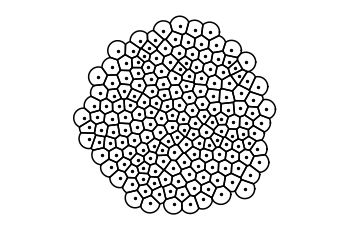

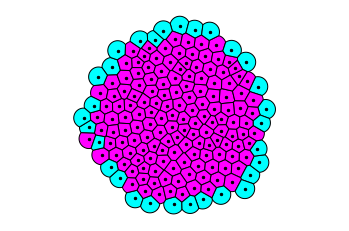

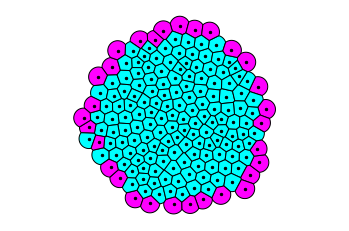

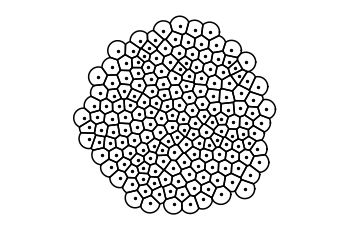

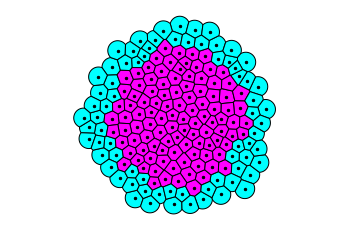

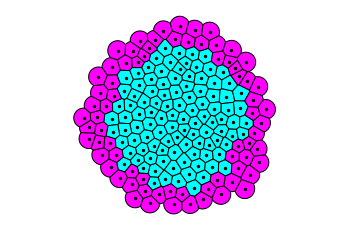

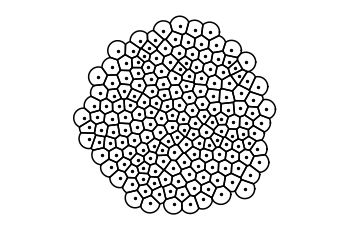

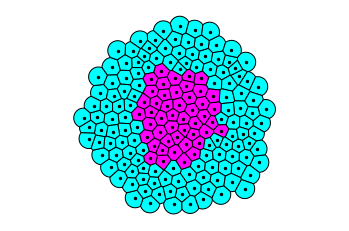

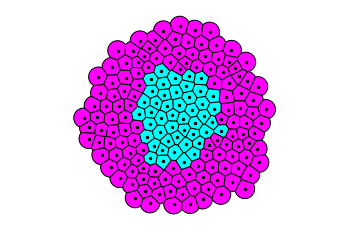

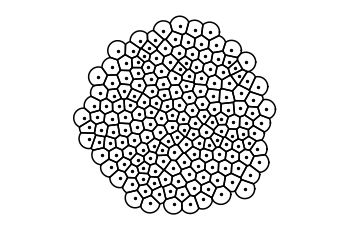

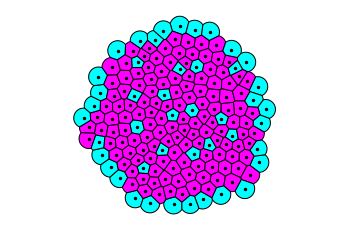

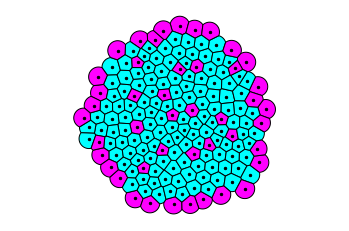

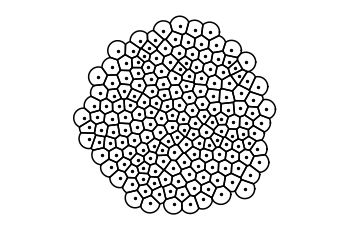

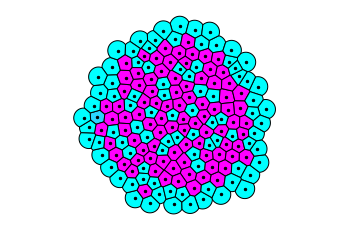

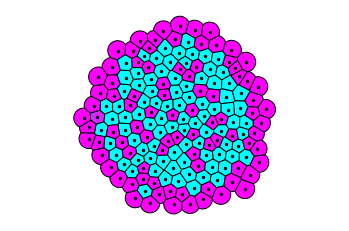

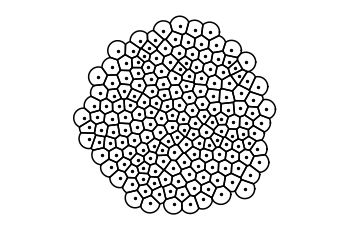

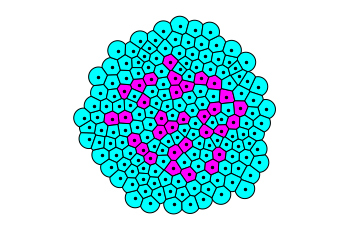

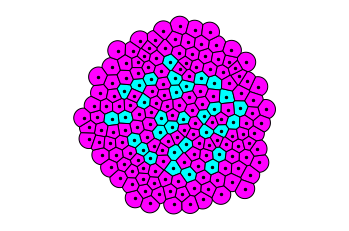

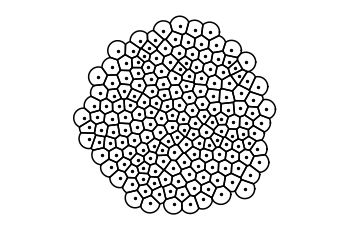

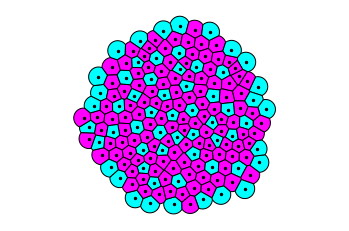

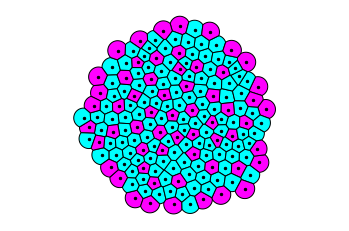

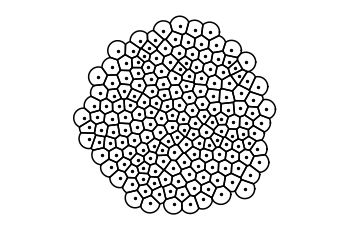

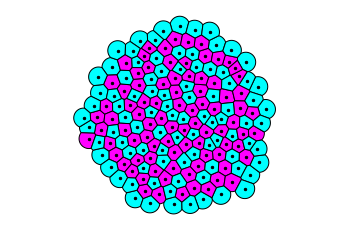

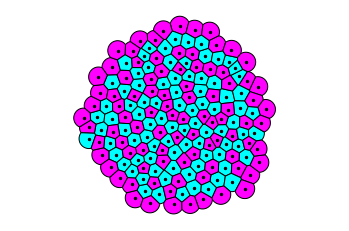

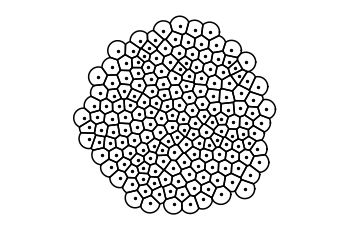

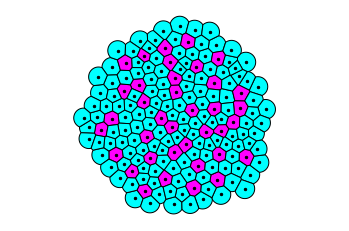

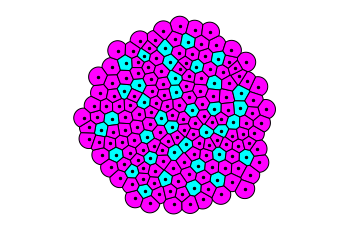

In [4]:
from Organoid2D_new import Organoid
import matplotlib.pyplot as plt


eps_G = [-6.5, -7, -7.5]
q = [.9, .5, .1]
# Plot the result
#plt.figure(figsize=(12,12))
for i in range(3):
    for j in range(3):
        #plt.subplot(3, 3, i*3 + j+1)
        org = Organoid()
        org.q = q[i]
        org.eps_G = eps_G[j]
        org.evolution(T=40, file = 'Organoid_mid.csv', mode='transcription')
        org.saveData(directory = 'Results/Publications/Signal Range/eps_G='+str(-org.eps_G)+' q='+str(org.q)+'/')
        #org.cellPlot(org.N, size=0)

0.717767937343398


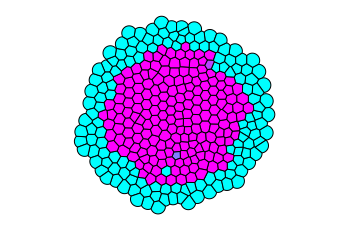

In [5]:
import numpy as np

org = Organoid()
org.q = .9
org.eps_G = -7
org.evolution(T=20, file = 'Organoid_large.csv', mode='transcription')
org.cellPlot(org.N, size=0)

# Weights
W = org.GraphDist
W[W > 1] = 0

# Fates
F = np.empty(org.N.shape)
F[org.N > org.G] = 1
F[org.N <= org.G] = 0

test = F - F.mean()
numerator = (test*test[:,None])*W
denominator = test**2

I = org.nofCells/np.sum(W)*np.sum(numerator)/np.sum(denominator)
print(I)

## Proportions

In [18]:
from Organoid2D import Organoid
import matplotlib.pyplot as plt
import numpy as np

org = Organoid()
s_max = org.r_G/org.gamma_G
upper_boundary = -org.eps_N + np.log(1 + np.exp(-org.eps_S-org.eps_NS)*s_max)
eps_G = np.linspace(6,upper_boundary,20)
q = 0.9

Ratio = np.empty(eps_G.shape)
for i in range(len(eps_G)):
    org = Organoid()
    org.eps_G = -eps_G[i]
    org.q = q
    org.evolution(T=40, file = 'Organoid_mid.csv', mode='transcription')
    F = [1 if org.N[i] >= org.G[i] else 0 for i in range(len(org.N))]

    Ratio[i] = np.sum(F)/org.nofCells

In [ ]:
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
plt.bar(eps_G, Ratio*100, width=0.06, color = 'm', edgecolor='k', alpha = 1, label='N+G-')
plt.bar(eps_G, (1-Ratio)*100, bottom=Ratio*100, width=0.06, color = 'c', edgecolor='k', alpha = 1, label='N-G+')
ticks = [0,20,40,60,80,100]
plt.yticks(ticks, [str(x)+'%' for x in ticks])
plt.xlabel('$-\Delta\epsilon_g$')
plt.ylabel('Proportions')
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.2)
plt.legend(framealpha=1)
plt.savefig('Results/Publications/Signal Range/Proportions q=0.9.pdf')
plt.savefig('Results/Publications/Signal Range/Proportions q=0.9.png')

## PCFs wrt Range

In [21]:
from Organoid2D import Organoid
import matplotlib.pyplot as plt
import numpy as np

def pcf(N, G, GraphDist):
    x = np.zeros(len(N))
    x[N > G] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        dist = GraphDist[ind].T[ind].T
        rho0 = sum(x)/len(x)
        rho1 = (sum(x)-1)/(len(x)-1)


        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = len(dist[dist==i])/len(GraphDist[GraphDist==i])/rho0/rho1

    return P

PN = []
PG = []
eps_G_list = []
ratio = 88/177
moran_list = []

for i in range(10):
    r = 1
    k = 0
    lower_boundary = -6
    upper_boundary = -7.86
    eps_G = (lower_boundary+upper_boundary)/2
    while r != ratio:
        org = Organoid()
        org.eps_G = eps_G
        org.q = 0.1*i
        org.evolution(T=100, file = 'Organoid_mid.csv', mode='transcription')
        org.moran()
        F = [1 if org.N[i] >= org.G[i] else 0 for i in range(len(org.N))]
        r = sum(F)/len(F)
        k += 1
        print('Iteration: '+str(k)+' Ratio: '+str(r)+' Current eps_G: '+str(eps_G))
        
        if r > ratio:
            lower_boundary = eps_G
        elif r <= ratio:
            upper_boundary = eps_G
            
        eps_G = (lower_boundary+upper_boundary)/2

    PN.append(pcf(org.N, org.G, org.GraphDist))
    PG.append(pcf(org.G, org.N, org.GraphDist))
    eps_G_list.append(eps_G)
    moran_list.append(org.Morans_I)

Iteration: 1 Ratio: 0.5028248587570622 Current eps_G: -6.93
Iteration: 2 Ratio: 0.2542372881355932 Current eps_G: -7.395
Iteration: 3 Ratio: 0.3672316384180791 Current eps_G: -7.1625
Iteration: 4 Ratio: 0.5028248587570622 Current eps_G: -7.04625
Iteration: 5 Ratio: 0.5028248587570622 Current eps_G: -7.104374999999999
Iteration: 6 Ratio: 0.3672316384180791 Current eps_G: -7.133437499999999
Iteration: 7 Ratio: 0.3672316384180791 Current eps_G: -7.118906249999999
Iteration: 8 Ratio: 0.3672316384180791 Current eps_G: -7.111640625
Iteration: 9 Ratio: 0.4519774011299435 Current eps_G: -7.1080078124999995
Iteration: 10 Ratio: 0.5028248587570622 Current eps_G: -7.10619140625
Iteration: 11 Ratio: 0.5028248587570622 Current eps_G: -7.107099609375
Iteration: 12 Ratio: 0.480225988700565 Current eps_G: -7.1075537109375
Iteration: 13 Ratio: 0.5028248587570622 Current eps_G: -7.10732666015625
Iteration: 14 Ratio: 0.4915254237288136 Current eps_G: -7.107440185546875
Iteration: 15 Ratio: 0.485875706214

Parameters used: [-7.107340850830078, -7.06078125, -7.024453125, -7.00265625, -7.00265625, -7.00265625, -7.00265625, -7.00265625, -7.064414062499999, -7.04625]


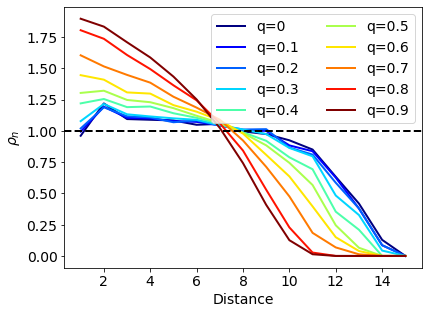

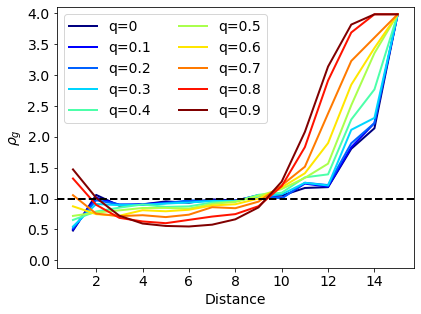

In [22]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,len(PN))
distances = [j for j in range(1,int(np.max(org.GraphDist))+1)]
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
q = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(len(PN)):
    rgba = cmap(test[i])
    
    plt.plot(distances,PN[i], color = rgba, lw=2, label='q='+str(q[i]))
    
plt.axhline(1, color='k', ls = 'dashed', lw = 2)
plt.legend(ncol=2)    
plt.xlabel('Distance')
plt.ylabel('$\\rho_n$')
#plt.ylim([0-0.12, max([np.max(PN), np.max(PG)])+0.12])
#plt.savefig('Results/Publications/Signal Range/pair_correlation_n.pdf', transparent=True)
#plt.savefig('Results/Publications/Signal Range/pair_correlation_n.png', transparent=True)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for i in range(len(PG)):
    rgba = cmap(test[i])
    
    plt.plot(distances,PG[i], color = rgba, lw=2, label='q='+str(q[i]))

plt.axhline(1, color='k', ls = 'dashed', lw = 2)
plt.legend(ncol=2)
plt.xlabel('Distance')
plt.ylabel('$\\rho_g$')
plt.ylim([0-0.12, max([np.max(PN), np.max(PG)])+0.12])
#sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
#cbar = plt.colorbar(sm)
#cbar.ax.set_yticklabels([])
#cbar.set_label('$-\Delta\epsilon_g$')
#plt.savefig('Results/Publications/Signal Range/pair_correlation_g.pdf', transparent=True)
#plt.savefig('Results/Publications/Signal Range/pair_correlation_g.png', transparent=True)

print('Parameters used:', eps_G_list)

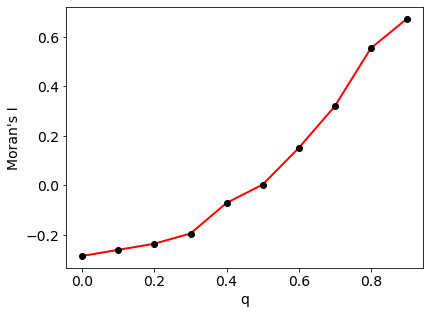

In [26]:
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
qs = [i*0.1 for i in range(10)]
plt.plot(qs, moran_list, color='r', lw=2)
plt.plot(qs, moran_list, 'o', color='k', lw=2)
plt.xlabel('q')
plt.ylabel('Moran\'s I')
plt.savefig('Results/Publications/Signal Range/morans_I.pdf', transparent=True)
plt.savefig('Results/Publications/Signal Range/morans_I.png', transparent=True)

## Organoid Data Application

In [10]:
# Save raw geometry of 3D organoids with cell radius as cutoff/2
from ExpData import ExpData
import numpy as np
import pandas as pd

dat = ExpData('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')
IDs = range(1, max(dat.id))

for ID in IDs:
    xyz = dat.pos[dat.id == ID]
    dat.graphdistance(ID)

    df1 = pd.DataFrame()
    df1['x-Position'] = xyz[:,0]
    df1['y-Position'] = xyz[:,1]
    df1['z-Position'] = xyz[:,2]
    df1['Radius'] = dat.cutoff/2*np.ones(len(xyz))
    df1.to_csv('Results/Publications/Signal Range/Simulation on Organoids/RawGeometry ID = '+str(ID)+'.csv', index=False)
    
    print('ID =', ID, 'Cutoff =', dat.cutoff)

ID = 1 Cutoff = 78.28519881356944
ID = 2 Cutoff = 77.40860585703781
ID = 3 Cutoff = 76.72474017976522
ID = 4 Cutoff = 70.49696492764156
ID = 5 Cutoff = 69.5487775391943
ID = 6 Cutoff = 72.69929324928721
ID = 7 Cutoff = 66.46358124087436
ID = 8 Cutoff = 71.73785597833984
ID = 9 Cutoff = 75.6212818550751
ID = 10 Cutoff = 78.92796717480849
ID = 11 Cutoff = 73.23233825071148
ID = 12 Cutoff = 78.99074368017875
ID = 13 Cutoff = 75.4134988858368
ID = 14 Cutoff = 62.269270501061044
ID = 15 Cutoff = 68.77688717615429
ID = 16 Cutoff = 70.78407916324252
ID = 17 Cutoff = 72.21291128111832
ID = 18 Cutoff = 67.59229943807313
ID = 19 Cutoff = 69.56666759693694
ID = 20 Cutoff = 69.58719781783357
ID = 21 Cutoff = 65.3065971711472
ID = 22 Cutoff = 69.668187527402
ID = 23 Cutoff = 68.63245762685867
ID = 24 Cutoff = 91.54915528400628
ID = 25 Cutoff = 87.61245222654445
ID = 26 Cutoff = 73.46468420833142
ID = 27 Cutoff = 79.042783150048
ID = 28 Cutoff = 82.9914366571044
ID = 29 Cutoff = 67.08335722829901
ID

In [9]:
#### import numpy as np
import pandas as pd
from Organoid3D import Organoid
from scipy.spatial.distance import cdist


#### Import Geometry ####
DATA = pd.read_csv('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')

IDs = [7, 65] #[14, 20, 29, 52, 62, 68]
Qs = [0.2, 0.4, 0.6, 0.8]
for ID in IDs:
    for Q in Qs:
        q = Q

        nofCalc = 0
        r = 0
        Data = DATA[DATA['OrganoidID'] == ID]
        ratio = len(Data[Data['Population']=='N+G-'])/len(Data[Data['Population']=='N-G+'])
        offset = 0.1
        lower_boundary = -6
        upper_boundary = -7.86
        eps_G = -6.4#(lower_boundary+upper_boundary)/2
        while (r < ratio - ratio*offset or r > ratio + ratio*offset) and nofCalc < 10:
            org = Organoid()
            org.eps_G = eps_G
            org.q = q
            org.nofSteps = 3000
            org.evolution(T=40, file = 'Results/Publications/Signal Range/Simulation on Organoids/RawGeometry ID = '+str(ID)+'.csv',
                          mode='transcription')
            F = [1 if org.N[i] >= org.G[i] else 0 for i in range(len(org.N))]
            r = sum(F)/(len(F)-sum(F))
            nofCalc += 1
            print('Iteration: '+str(nofCalc)+' Current: '+str(r)+' Aim: '+str(ratio)+' Current eps_G: '+str(eps_G))

            if r > ratio:
                lower_boundary = eps_G
            elif r <= ratio:
                upper_boundary = eps_G

            eps_G0 = eps_G
            eps_G = (lower_boundary+upper_boundary)/2

        df = pd.DataFrame()
        df['x-Position'] = org.xyz[:,0]
        df['y-Position'] = org.xyz[:,1]
        df['z-Position'] = org.xyz[:,2]
        df['Radius'] = org.r
        df['Nanog'] = org.N
        df['Gata6'] = org.G
        df['eps_G'] = eps_G0

        df.to_csv('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv', index=False)
        print('Finished!!!')

Iteration: 1 Current: 3.5837696335078535 Aim: 4.343283582089552 Current eps_G: -6.4
Iteration: 2 Current: 6.852017937219731 Aim: 4.343283582089552 Current eps_G: -6.2
Iteration: 3 Current: 4.8561872909699 Aim: 4.343283582089552 Current eps_G: -6.300000000000001
Iteration: 4 Current: 4.15 Aim: 4.343283582089552 Current eps_G: -6.3500000000000005
Finished!!!
Iteration: 1 Current: 4.15 Aim: 4.343283582089552 Current eps_G: -6.4
Finished!!!
Iteration: 1 Current: 4.759868421052632 Aim: 4.343283582089552 Current eps_G: -6.4
Finished!!!
Iteration: 1 Current: 6.089068825910931 Aim: 4.343283582089552 Current eps_G: -6.4
Iteration: 2 Current: 0.8373557187827911 Aim: 4.343283582089552 Current eps_G: -7.130000000000001
Iteration: 3 Current: 2.2010968921389398 Aim: 4.343283582089552 Current eps_G: -6.765000000000001
Iteration: 4 Current: 3.5718015665796345 Aim: 4.343283582089552 Current eps_G: -6.5825000000000005
Iteration: 5 Current: 4.576433121019108 Aim: 4.343283582089552 Current eps_G: -6.49125

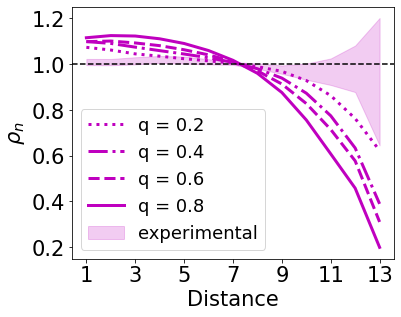

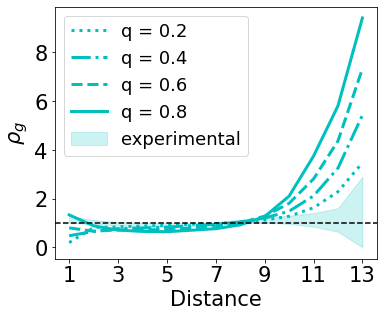

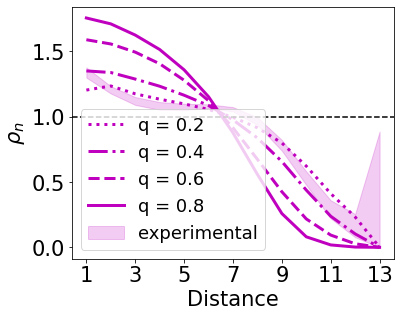

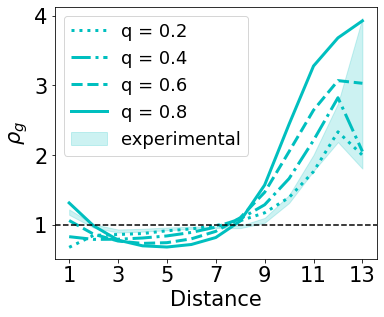

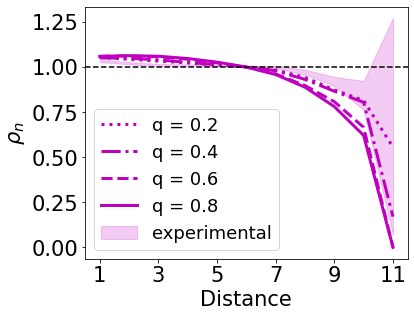

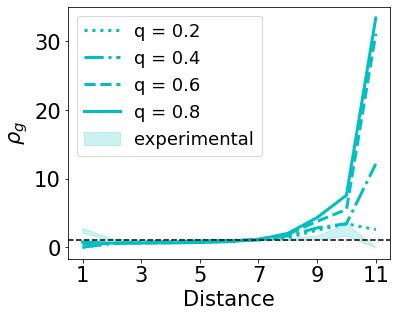

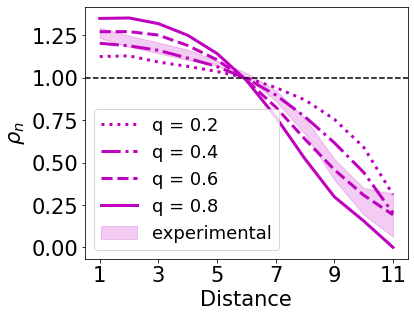

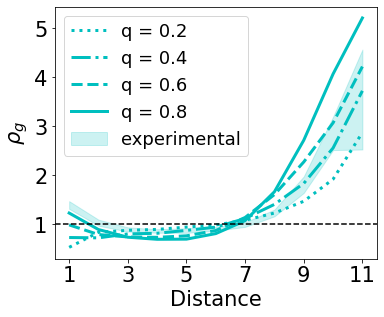

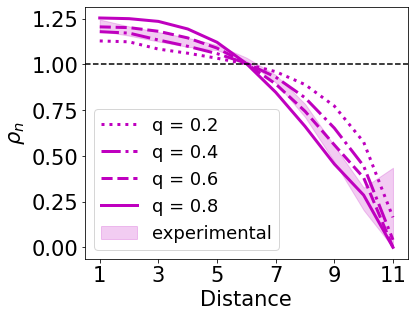

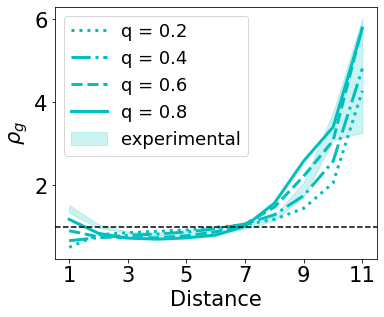

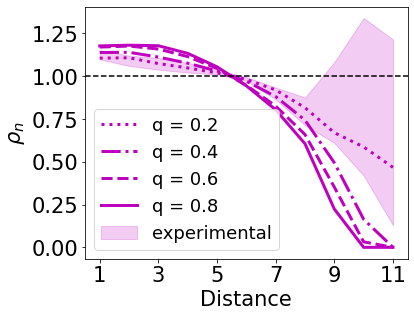

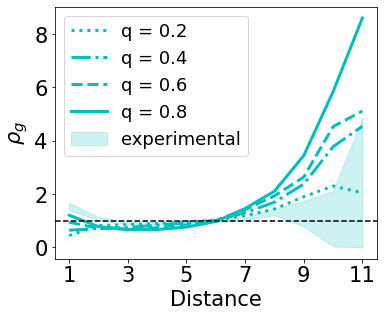

In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Functions import graphdistance3D, loadExpData, pc_bounds
from ExpData import ExpData
from Organoid3D import Organoid

IDs = [7, 14, 29, 52, 62, 65] #[20, 68]
Q = [0.2,0.4,0.6,0.8]
styles = ['dotted', 'dashdot', 'dashed', 'solid']

dat = ExpData('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')

for ID in IDs:
    dat.pcf_bounds(ID, 1000, plot = False)
    
    # NANOG
    plt.figure(figsize=[6.4, 4.8])
    plt.rc('font', size=14*1.5)
    for i, q in enumerate(Q):

        org = Organoid()
        org.initialConditions('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        Data = pd.read_csv('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        org.N = Data['Nanog'].to_numpy()
        org.G = Data['Gata6'].to_numpy()
        org.GraphDist = dat.GraphDist[ID]
        org.pcf(plot = False)

        ranges = list(range(1,len(org.pcf_N)+1))
        plt.plot(ranges, org.pcf_N, 'm', lw=3, linestyle=styles[i], label='q = '+str(q))
        plt.xlabel('Distance')
        plt.ylabel('$\\rho_n$')

    ranges = list(range(1,len(org.pcf_N)+1))
    plt.axhline(1, color='black', linestyle='dashed')
    plt.fill_between(ranges, dat.pcf[ID][0], dat.pcf[ID][2], color='m', alpha=0.2, label='experimental')
    plt.legend(fontsize=18)
    xticks = list(range(1,int(np.max(org.GraphDist))+1, 2))
    plt.xticks(xticks)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.2)
    plt.savefig("Results/Publications/Signal Range/PCF NANOG ID = " + str(ID) + ".pdf", transparent=True)
    plt.savefig("Results/Publications/Signal Range/PCF NANOG ID = " + str(ID) + ".png", transparent=True)

    # GATA6
    plt.figure(figsize=[6.4, 4.8])
    plt.rc('font', size=14*1.5)
    for i, q in enumerate(Q):

        org = Organoid()
        org.initialConditions('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        Data = pd.read_csv('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        org.N = Data['Nanog'].to_numpy()
        org.G = Data['Gata6'].to_numpy()
        org.GraphDist = dat.GraphDist[ID]
        org.pcf(plot = False)

        ranges = list(range(1,len(org.pcf_G)+1))
        plt.plot(ranges, org.pcf_G, 'c', lw=3, linestyle=styles[i], label='q = '+str(q))
        plt.xlabel('Distance')
        plt.ylabel('$\\rho_g$')

    ranges = list(range(1,len(org.pcf_G)+1))
    plt.axhline(1, color='black', linestyle='dashed')
    plt.fill_between(ranges, dat.pcf[ID][3], dat.pcf[ID][5], color='c', alpha=0.2, label='experimental')
    plt.legend(fontsize=18)
    xticks = list(range(1,int(np.max(org.GraphDist))+1, 2))
    plt.xticks(xticks)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.2)
    plt.savefig("Results/Publications/Signal Range/PCF GATA6 ID = " + str(ID) + ".pdf", transparent=True)
    plt.savefig("Results/Publications/Signal Range/PCF GATA6 ID = " + str(ID) + ".png", transparent=True)

Organoid 62 is 48h old
Organoid 62 consists of 1051 cells
Organoid 62 consists of 546 NANOG cells
Organoid 62 consists of 276 GATA6 cells
Organoid 62 has a NANOG:GATA6 ratio of 1.9782608695652173


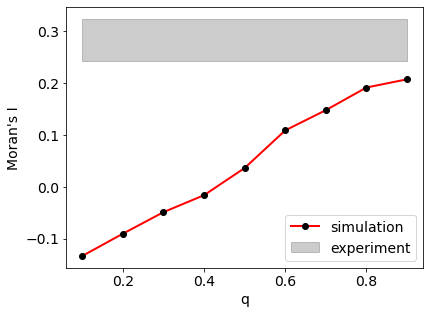

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Functions import graphdistance3D, loadExpData, moran_bounds

def moran(x, GraphDist):
    
    W = np.copy(GraphDist)
    W[W > 1] = 0
    y = x - x.mean()

    numerator = np.dot(y, np.dot(W, y))
    denominator = np.sum(y**2)

    return len(x)/np.sum(W)*numerator/denominator


ID = 62 #[14, 20, 29, 52, 62, 68]

N, G, Pop, Pos = loadExpData(ID)
GraphDist = graphdistance3D(Pos, cutoff=85)
I_min, I_max = moran_bounds(Pop, GraphDist, 1000)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
Qs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
Is = []
for q in Qs:
    Data = pd.read_csv('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' 85.csv')
    N = Data['Nanog']
    G = Data['Gata6']
    F = np.zeros(len(N))
    F[N > G] = 1
    
    Is.append(moran(F, GraphDist))
        
plt.plot(Qs, Is, 'ro-', mfc='k', lw=2, mec='k', label='simulation')
plt.fill_between(Qs, [I_min]*len(Qs), [I_max]*len(Qs), color='k', alpha=0.2, label='experiment')
plt.xlabel('q')
plt.ylabel('Moran\'s I')
plt.legend(loc='lower right')
plt.savefig("Results/Publications/Signal Range/Moran ID = " + str(ID) + ".pdf", transparent=True)
plt.savefig("Results/Publications/Signal Range/Moran ID = " + str(ID) + ".png", transparent=True)

1.) Moran's I = -0.024504231400783127
2.) Moran's I = 0.6405325443786983


(-0.047856482107173005,
 1.0444486265010104,
 -0.03680711558035655,
 1.0029954844857163)

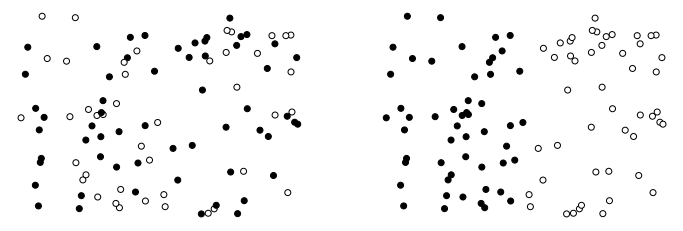

In [67]:
import networkx as nx
import itertools
import numpy as np
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def graphdistance(pos, cutoff = 90):
    Gr = nx.Graph()
    dist = cdist(pos, pos)
    tri = Delaunay(pos)

    for nodes in tri.simplices:
        for path in list(itertools.combinations(nodes, 2)):
            if dist[path[0],path[1]] < cutoff:
                nx.add_path(Gr, path)

    dist_dict = dict(nx.all_pairs_dijkstra_path_length(Gr))
    GraphDist = np.empty([len(pos), len(pos)])
    for i in range(len(pos)):
        for j in range(len(pos)):
            GraphDist[i,j] = dist_dict[i][j]
        
    return GraphDist
 
def moran(x, W):
    
    W[W > 1] = 0
    y = x - x.mean()

    numerator = np.dot(y, np.dot(W, y))
    denominator = np.sum(y**2)

    return len(x)/np.sum(W)*numerator/denominator

# random Daten, ersetzen durch Organoiddaten
pos = np.random.random([100,3])          # x,y,z Koordinaten

# Bsp. 1: Zellschicksal random
fate1 = np.round(np.random.random(100))

# Bsp. 2: Zellschicksal sortiert
fate2 = np.zeros(100)
fate2[pos[:,0] > (max(pos[:,0])-min(pos[:,0]))/2] = 1    # Zellschicksal sortiert. Links 0 rechts 1

W = graphdistance(pos)
print('1.) Moran\'s I =', moran(fate1, W))
print('2.) Moran\'s I =', moran(fate2, W))
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(pos[:,0], pos[:,1], c=fate1, edgecolor='k', cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.scatter(pos[:,0], pos[:,1], c=fate2, edgecolor='k', cmap='gray')
plt.axis('off')

Organoid 14 is 48h old
Organoid 14 consists of 1531 cells
Organoid 14 consists of 579 NANOG cells
Organoid 14 consists of 608 GATA6 cells
Organoid 14 has a NANOG:GATA6 ratio of 0.9523026315789473


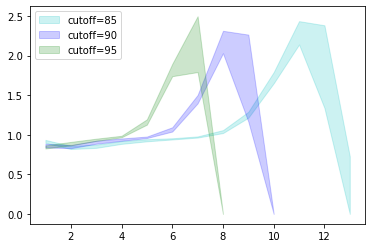

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Functions import loadExpData, pc_bounds
from scipy.spatial.distance import cdist

ID = 14 #[14, 20, 29, 52, 62, 68]

N, G, Pop, Pos = loadExpData(ID)
dist = cdist(Pos, Pos)
GraphDist1 = np.floor(dist/30)
PN_min1, PN_max1, PG_min1, PG_max1 = pc_bounds(Pop, GraphDist1, 100)
GraphDist2 = np.floor(dist/40)
PN_min2, PN_max2, PG_min2, PG_max2 = pc_bounds(Pop, GraphDist2, 100)
GraphDist3 = np.floor(dist/50)
PN_min3, PN_max3, PG_min3, PG_max3 = pc_bounds(Pop, GraphDist3, 100)

ranges1 = list(range(1,len(PN_min1)+1))
ranges2 = list(range(1,len(PN_min2)+1))
ranges3 = list(range(1,len(PN_min3)+1))
plt.fill_between(ranges1, PG_min1, PG_max1, color='c', alpha=0.2, label='cutoff=85')
plt.fill_between(ranges2, PG_min2, PG_max2, color='b', alpha=0.2, label='cutoff=90')
plt.fill_between(ranges3, PG_min3, PG_max3, color='g', alpha=0.2, label='cutoff=95')
plt.legend(loc='upper left')

## Cell number

In [1]:
from Organoid2D import Organoid
import matplotlib.pyplot as plt
import numpy as np

q = [.9, .5, .1]
# Plot the result
fig = plt.figure(figsize=[6.4, 4.8])
for i in range(3):
    #plt.subplot(3, 3, i*3 + j+1)
    org_s = Organoid()
    org_m = Organoid()
    org_l = Organoid()
    org_s.q = q[i]
    org_m.q = q[i]
    org_l.q = q[i]
    org_s.evolution(T=100, file = 'Organoid_small.csv', mode='transcription')
    org_m.evolution(T=100, file = 'Organoid_mid.csv', mode='transcription')
    org_l.evolution(T=100, file = 'Organoid_large.csv', mode='transcription')
    
    size = 1000/len(org_l.xy)
    #org.saveData(directory = 'Results/Publications/Signal Range/'+size[j]+' q='+str(org.q)+'/')
    lims = np.max(abs(org_l.xy))+1.5
    plt.figure(figsize=[6.4, 4.8])
    org_s.cellPlot(org_s.N, size=size)
    plt.xlim([-lims, lims])
    plt.ylim([-lims, lims])
    plt.gca().set_adjustable("box")
    plt.savefig('Results/Publications/Signal Range/Cell number variation/small q='+str(org_s.q)+'.png', transparent=True)
    plt.savefig('Results/Publications/Signal Range/Cell number variation/small q='+str(org_s.q)+'.pdf', transparent=True)
    
    plt.figure(figsize=[6.4, 4.8])
    org_m.cellPlot(org_m.N, size=size)
    plt.xlim([-lims, lims])
    plt.ylim([-lims, lims])
    plt.gca().set_adjustable("box")
    plt.savefig('Results/Publications/Signal Range/Cell number variation/medium q='+str(org_m.q)+'.png', transparent=True)
    plt.savefig('Results/Publications/Signal Range/Cell number variation/medium q='+str(org_m.q)+'.pdf', transparent=True)
    
    plt.figure(figsize=[6.4, 4.8])
    org_l.cellPlot(org_l.N, size=size)
    plt.xlim([-lims, lims])
    plt.ylim([-lims, lims])
    plt.gca().set_adjustable("box")
    plt.savefig('Results/Publications/Signal Range/Cell number variation/large q='+str(org_l.q)+'.png', transparent=True)
    plt.savefig('Results/Publications/Signal Range/Cell number variation/large q='+str(org_l.q)+'.pdf', transparent=True)
    
    plt.figure(figsize=[6.4, 4.8])
    org_l.pcf(ls='solid', lw=3, font_size=14*1.5)
    org_s.pcf(ls='dotted', lw=3, font_size=14*1.5)
    org_m.pcf(ls='dashed', lw=3, font_size=14*1.5)
    plt.legend(['N+G-', 'N-G+'], fontsize=18)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.2)
    
    plt.savefig('Results/Publications/Signal Range/Cell number variation/pcf q='+str(org_s.q)+'.png', transparent=True)
    plt.savefig('Results/Publications/Signal Range/Cell number variation/pcf q='+str(org_s.q)+'.pdf', transparent=True)

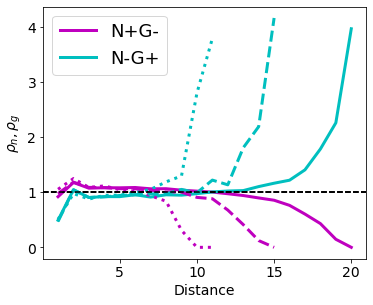

In [12]:
plt.rc('font', size=14*1.5)
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14*1.5)
org_l.pcf(ls='solid', lw=3, legend=True)
org_s.pcf(ls='dotted', lw=3, legend=False)
org_m.pcf(ls='dashed', lw=3, legend=False)
plt.rc('font', size=14*1.5)
plt.legend(['N+G-', 'N-G+'], fontsize=18)
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.2)

## Cell division characterization

In [1]:
#from Organoid2D import Organoid
from Organoid3D import Organoid
import matplotlib.pyplot as plt
import numpy as np


T = 24
N = 10
q = [i*0.1 for i in range(10)]

Morans_Div = np.empty([len(q), N])
Morans_Sta = np.empty([len(q), N])
for i in range(len(q)):
    for j in range(N):
        print('Iteration:', i, j)      
        org = Organoid()
        org.q = q[i]
        
        # Division
        org.evolution(T=T)
        org.moran()
        Morans_Div[i,j] = org.Morans_I

        # Static
        N0 = org.r_N/org.gamma_N*3/4
        G0 = org.r_N/org.gamma_N*3/4
        org.u = np.append(np.random.normal(N0, N0*0.01, org.nofCells),
                          np.random.normal(G0, G0*0.01, org.nofCells))
        org.N = org.u[:org.nofCells]
        org.G = org.u[org.nofCells:]
        org.evolution(T=T, mode='transcription')
        org.moran()
        Morans_Sta[i,j] = org.Morans_I
    
plt.scatter(q, Morans_Div.mean(axis=1))
plt.scatter(q, Morans_Sta.mean(axis=1))

Iteration: 0 0
Iteration: 0 1
Iteration: 0 2
Iteration: 0 3
Iteration: 0 4
Iteration: 0 5
Iteration: 0 6
Iteration: 0 7
Iteration: 0 8
Iteration: 0 9
Iteration: 1 0
Iteration: 1 1
Iteration: 1 2
Iteration: 1 3
Iteration: 1 4
Iteration: 1 5
Iteration: 1 6
Iteration: 1 7
Iteration: 1 8
Iteration: 1 9
Iteration: 2 0
Iteration: 2 1
Iteration: 2 2
Iteration: 2 3
Iteration: 2 4
Iteration: 2 5
Iteration: 2 6
Iteration: 2 7
Iteration: 2 8
Iteration: 2 9
Iteration: 3 0
Iteration: 3 1
Iteration: 3 2
Iteration: 3 3
Iteration: 3 4
Iteration: 3 5
Iteration: 3 6
Iteration: 3 7
Iteration: 3 8
Iteration: 3 9
Iteration: 4 0
Iteration: 4 1
Iteration: 4 2
Iteration: 4 3
Iteration: 4 4
Iteration: 4 5
Iteration: 4 6
Iteration: 4 7
Iteration: 4 8
Iteration: 4 9
Iteration: 5 0
Iteration: 5 1
Iteration: 5 2
Iteration: 5 3
Iteration: 5 4
Iteration: 5 5
Iteration: 5 6
Iteration: 5 7
Iteration: 5 8
Iteration: 5 9
Iteration: 6 0
Iteration: 6 1
Iteration: 6 2
Iteration: 6 3
Iteration: 6 4
Iteration: 6 5
Iteration:

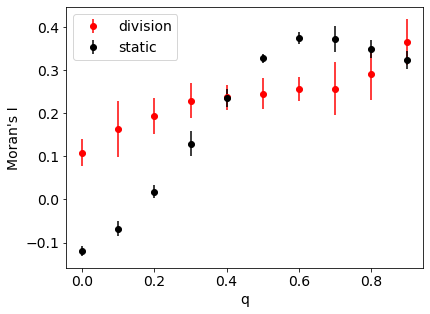

In [2]:
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)

plt.errorbar(q, Morans_Div.mean(axis=1), Morans_Div.std(axis=1), linestyle='None', marker='o', color='r', label='division')
plt.errorbar(q, Morans_Sta.mean(axis=1), Morans_Sta.std(axis=1), linestyle='None', marker='o', color='k', label='static')
plt.legend()
plt.xlabel('q')
plt.ylabel('Moran\'s I')
plt.savefig('morans 3D.png', transparent=True)
plt.savefig('morans 3D.pdf', transparent=True)

In [1]:
from ExpData import ExpData
import matplotlib.pyplot as plt
import numpy as np

dat = ExpData('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')
maxID = np.max(dat.id)

for ID in range(1, maxID+1):
    print(ID, 'of', maxID)
    plt.figure(figsize=[6.4, 4.8])
    dat.pcf_bounds(ID, 100)
    plt.title('ID = ' + str(ID) + ', Stage = ' + dat.stage[dat.id == ID][0] + ', #Cells = ' + str(len(dat.stage[dat.id == ID])))
    plt.savefig('Results/Pair Correlations mean + 2std/ID='+str(ID)+'.png', transparent=True)

1 of 76
2 of 76
3 of 76
4 of 76
5 of 76
6 of 76
7 of 76
8 of 76
9 of 76
10 of 76
11 of 76


C:\Users\sis85wc\Desktop\Cell-Differentiation\ExpData.py:107: RuntimeWarning: invalid value encountered in double_scalars
  PG[i-1,j] = len(pairs_G[pairs_G==i])/len(GraphDist[GraphDist==i])/rho_G[j]


12 of 76


C:\Users\sis85wc\Desktop\Cell-Differentiation\ExpData.py:107: RuntimeWarning: invalid value encountered in double_scalars
  PG[i-1,j] = len(pairs_G[pairs_G==i])/len(GraphDist[GraphDist==i])/rho_G[j]


13 of 76
14 of 76
15 of 76
16 of 76
17 of 76
18 of 76
19 of 76
20 of 76
21 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


22 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


23 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


24 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


25 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


26 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


27 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


28 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


29 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


30 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


31 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


32 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


33 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


34 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


35 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


36 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


37 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


38 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


39 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


40 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


41 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


42 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


43 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


44 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


45 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


46 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


47 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


48 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


49 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


50 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


51 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


52 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


53 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


54 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


55 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


56 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


57 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


58 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


59 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


60 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


61 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


62 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


63 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


64 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


65 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


66 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


67 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


68 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


69 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


70 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


71 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


72 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


73 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


74 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


75 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


76 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


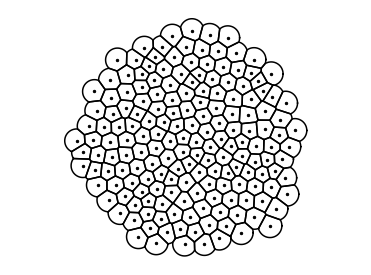

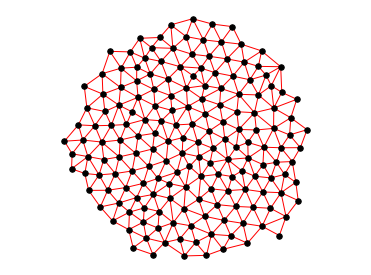

In [142]:
from Organoid2D import Organoid
import networkx as nx
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import numpy as np
import itertools
import matplotlib.pyplot as plt

org = Organoid()
org.evolution(T = 0.1, file = 'Organoid_mid.csv', mode = 'transcription')

Gr = nx.Graph()
dist = cdist(org.xy, org.xy)
tri = Delaunay(org.xy)

plt.figure(figsize = (6.4,4.8))
rr = org.r + org.r[:,None]
for nodes in tri.simplices:
    for path in list(itertools.combinations(nodes, 2)):
        if dist[path[0],path[1]] < rr[path[0],path[1]]:
            nx.add_path(Gr, path)
            
org.cellPlot()
plt.savefig('Results/Publications/Signal Range/Geometry.png', transparent=True)
plt.savefig('Results/Publications/Signal Range/Geometry.pdf', transparent=True)

plt.figure(figsize = (6.4,4.8))
plt.plot()
nx.draw(Gr, org.xy, node_size=30, edge_color='r', node_color='k')
plt.axis('equal')
plt.savefig('Results/Publications/Signal Range/CellGraph.png', transparent=True)
plt.savefig('Results/Publications/Signal Range/CellGraph.pdf', transparent=True)